<a href="https://colab.research.google.com/github/BrookMaoDev/threat-trace-ai-hackthevalley8/blob/main/malaria_cell_classification_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dependencies


In [1]:
# Standard library imports
import random
import shutil

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

# Google Colab specific imports
from google.colab import files

# Check versions
print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.__version__)
print("TensorFlow version:", tf.__version__)
print("TensorFlow Datasets version:", tfds.__version__)

# Load Data


In [2]:
(train_ds, valid_ds), ds_info = tfds.load(
    name="malaria",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteAXU9DP/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


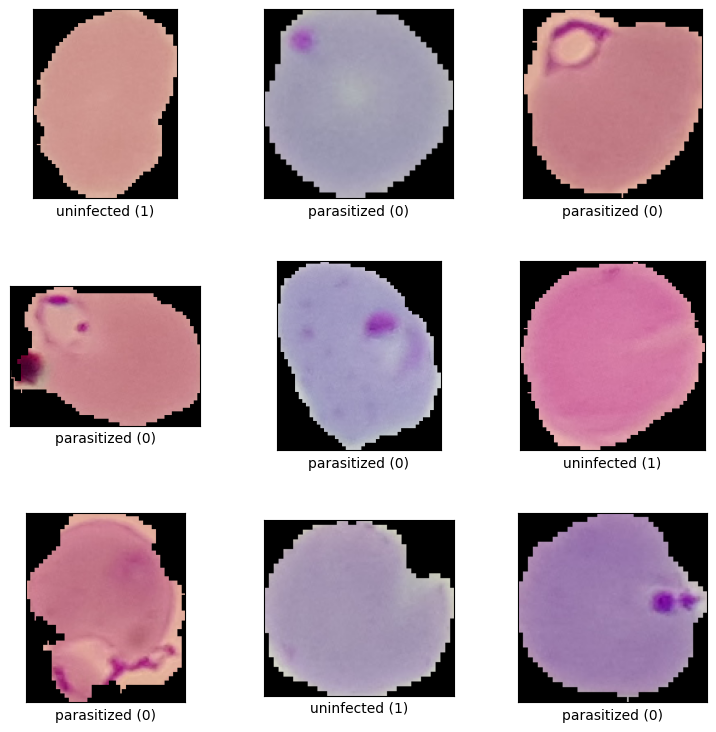

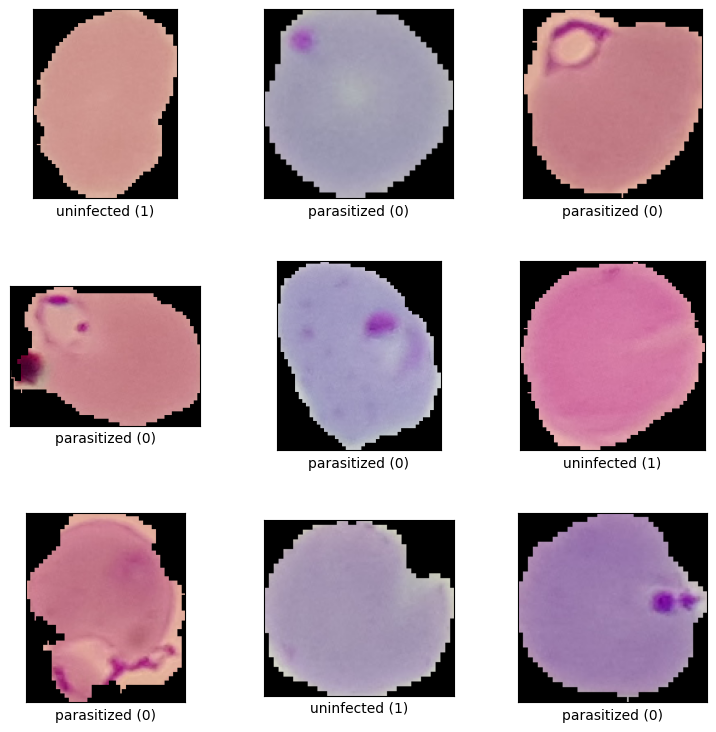

In [3]:
tfds.show_examples(train_ds, ds_info)

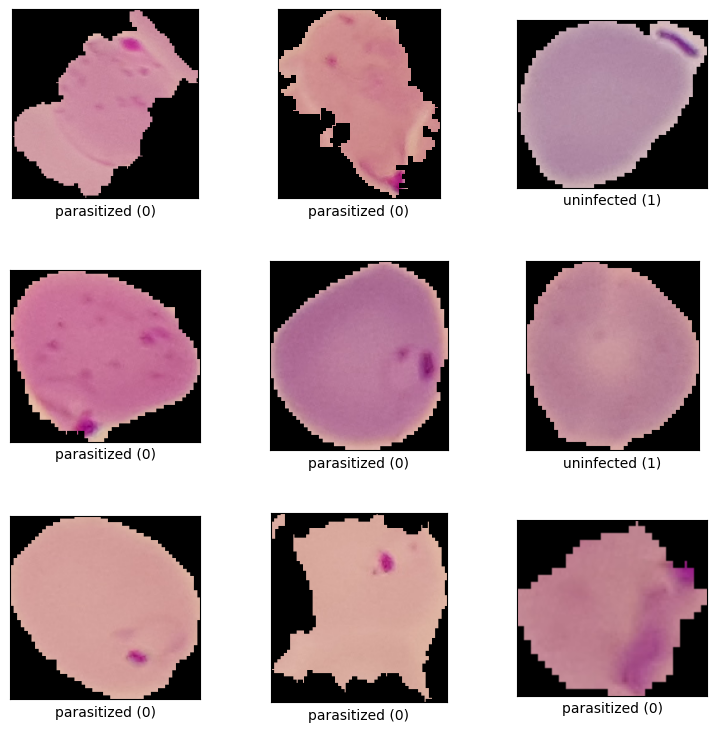

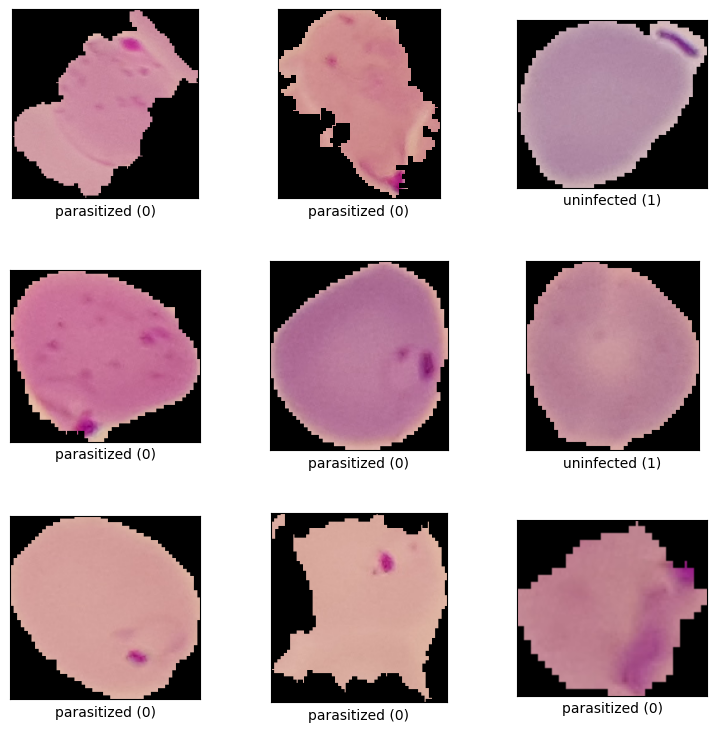

In [4]:
tfds.show_examples(valid_ds, ds_info)

# Resize Images


In [5]:
SIDE_LEN = 128


def resize_image(image, label):
    image = tf.image.resize(image, (SIDE_LEN, SIDE_LEN))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label


train_ds = train_ds.map(resize_image)
valid_ds = valid_ds.map(resize_image)

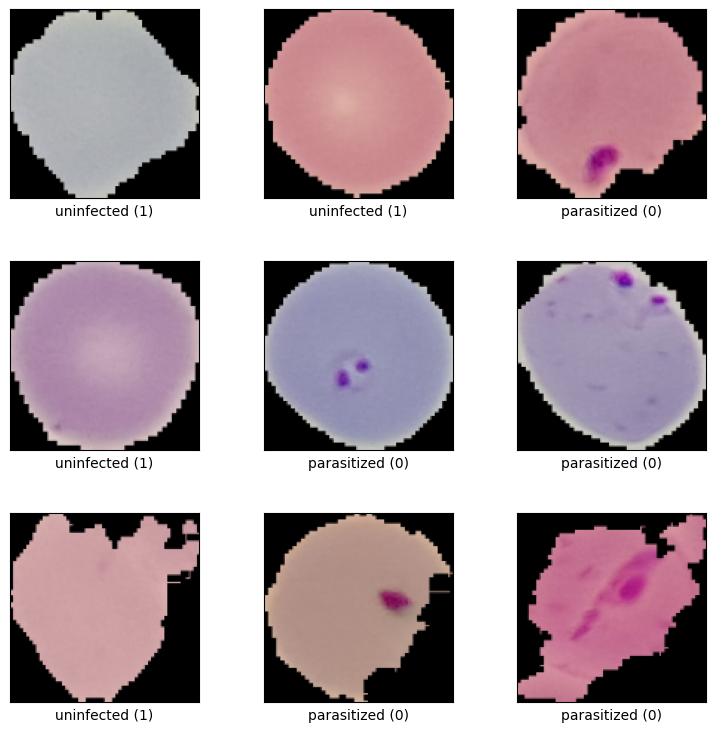

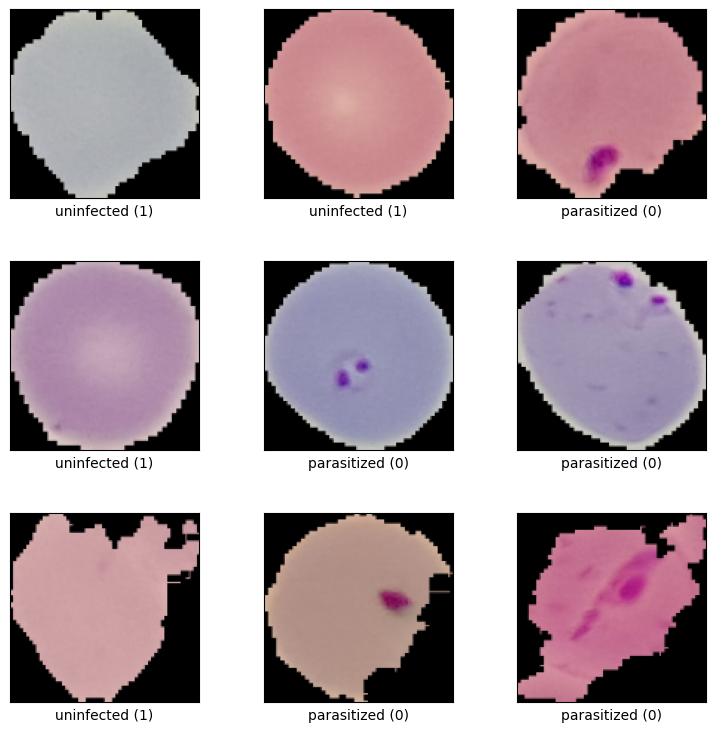

In [6]:
tfds.show_examples(train_ds, ds_info)

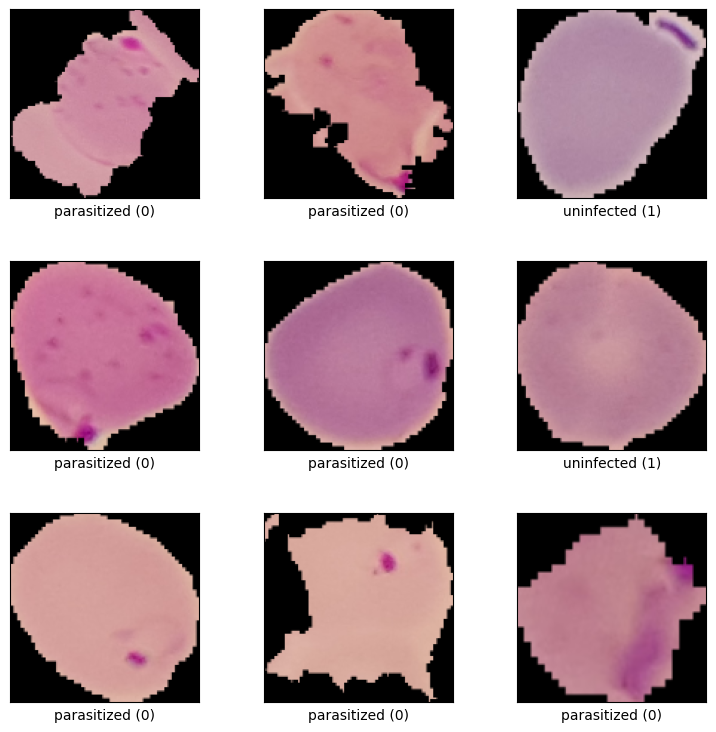

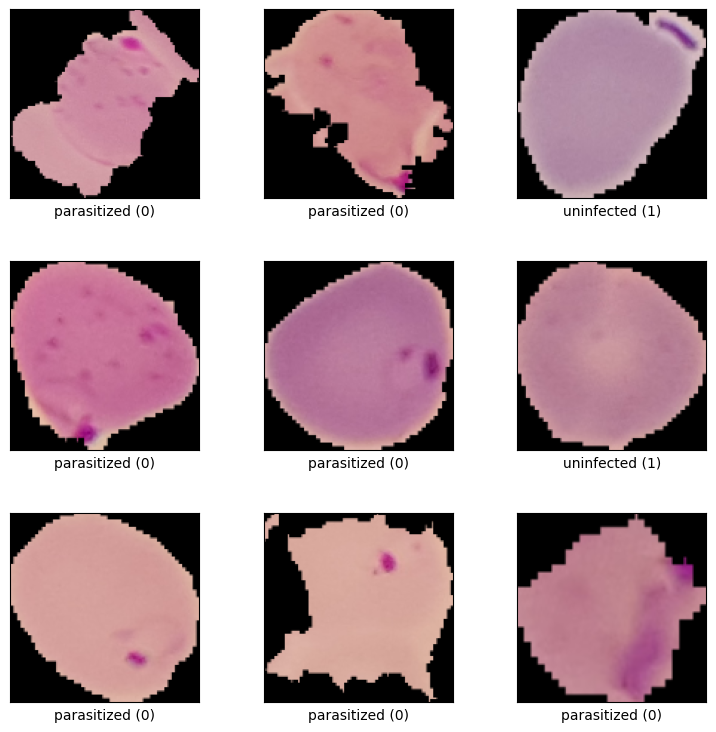

In [7]:
tfds.show_examples(valid_ds, ds_info)

# Caching, Batching, and Prefetching


In [8]:
BATCH_SIZE = 32

train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Neural Network Building


In [9]:
# Set seeds for reproducibility of RNG
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Creates a typical neural network with layers of nodes
model = models.Sequential()

In [10]:
# Jumbles up the input data.
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

# Having this layer ensures that our input training data is different each time,
# resulting in a more robust model.
model.add(data_augmentation)

Applies convolutional filters to the input image, generating feature maps before using max pooling to reduce their dimensions.

Initially, the filters have randomized weights (although constrained by preset random seeds). Over time, the neural network adjusts these weights through training, akin to the learning process in hidden layers.

[Learn More](https://www.ibm.com/topics/convolutional-neural-networks)


In [11]:
model.add(
    layers.Conv2D(128, (3, 3),
                  activation="relu",
                  input_shape=(SIDE_LEN, SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1))

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Neural Network Training


In [13]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=3, verbose=1)

Epoch 1/10
689/689 [==============================] - 2159s 3s/step - loss: 0.5312 - accuracy: 0.6623 - val_loss: 0.2175 - val_accuracy: 0.9327
Epoch 2/10
689/689 [==============================] - 2003s 3s/step - loss: 0.1951 - accuracy: 0.9267 - val_loss: 0.1584 - val_accuracy: 0.9396
Epoch 3/10
689/689 [==============================] - 1998s 3s/step - loss: 0.1559 - accuracy: 0.9455 - val_loss: 0.1531 - val_accuracy: 0.9537
Epoch 4/10
689/689 [==============================] - 2034s 3s/step - loss: 0.1467 - accuracy: 0.9509 - val_loss: 0.1500 - val_accuracy: 0.9526
Epoch 5/10
689/689 [==============================] - 1990s 3s/step - loss: 0.1444 - accuracy: 0.9508 - val_loss: 0.1462 - val_accuracy: 0.9521
Epoch 6/10
689/689 [==============================] - 1999s 3s/step - loss: 0.1382 - accuracy: 0.9535 - val_loss: 0.1436 - val_accuracy: 0.9559
Epoch 7/10
689/689 [==============================] - 1993s 3s/step - loss: 0.1358 - accuracy: 0.9545 - val_loss: 0.1434 - val_accuracy:

# Deployment


In [ ]:
# Save the trained model
model.save("malaria_classification_model")

# Download the trained model
shutil.make_archive("malaria_classification_model", "zip",
                    "malaria_classification_model")
files.download("malaria_classification_model.zip")